# Figure 2a - Examples

Updated: May 18, 2022

The following notebook plots RFLO and REINFORCE examples that are used in Figure 2 of the NeurIPS submission.

In [31]:
folder = 'figs-2022-5-18/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


### Train RNN on four targets

In [4]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

### BPTT, RFLO and REINFORCE with the same parameters

4it [00:00, 39.65it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fd6d97cdf78>
>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:15, 96.47it/s] 


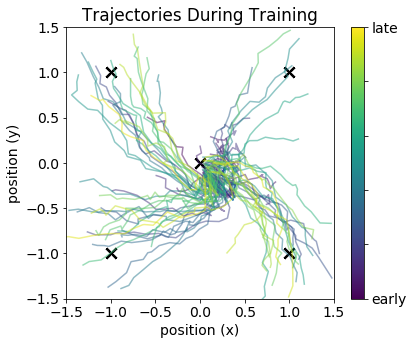

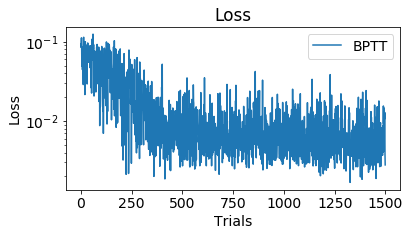

In [12]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(4))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
bptt = BPTT(net0,apply_to=['w_rec'],online=False) # something strange happening here
sim0.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['loss'], plot=True, plot_freq=20)




5000it [00:53, 92.77it/s]


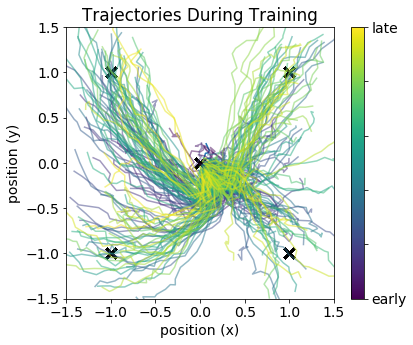

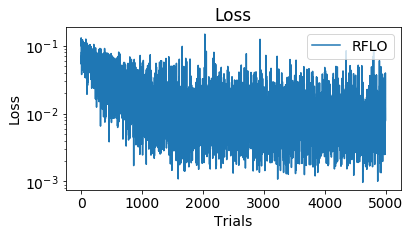

In [17]:
net1 = RNN(params)
sim1 = Simulation(net1)
rflo = RFLO(net1,apply_to=['w_rec'],online=False)
sim1.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)


50000it [08:59, 92.75it/s]


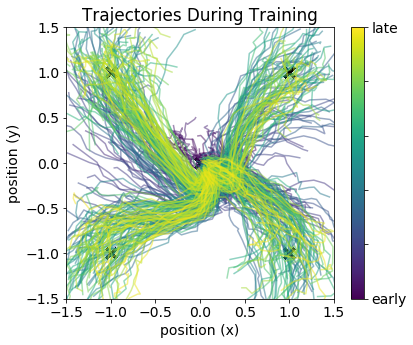

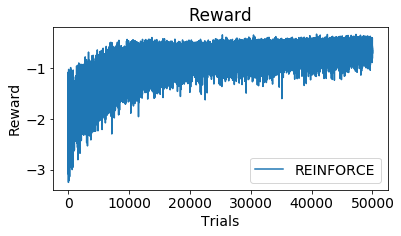

In [13]:
net2 = RNN(params)
sim2 = Simulation(net2)
reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False, tau_reward=5)
sim2.run_session(n_trials=50000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=100)


In [40]:
def plot_trained_trajectories(sim, tasks: List[Task],colors=cycle(['teal','C4','darkblue','tomato']),num_examples:int = 4, **kwargs):
    
    """ Plot trajectories after training """
    
    if 'fig' in kwargs.keys():
        fig = kwargs['fig']
        ax = fig.gca()
    else:
        fig,ax = plt.subplots(1,1,figsize=(5,5),squeeze=True) 
        
    if 'title' in kwargs.keys():
        title = kwargs['title']
    else:
        title = 'Trajectories after Training'
    
    for task in tasks:
        c = next(colors)
        for count in range(num_examples):

            sim.run_trial(task,probe_types=['h','pos'],train=False)
            ax.plot(sim.probes['pos'].squeeze()[:,0],sim.probes['pos'].squeeze()[:,1],'-',color=c,linewidth=1)

    ax.set_xticks([-1,1])
    ax.set_yticks([-1,1])
    for task in tasks:
        c = next(colors)
        ax.plot(task.y_target[0,:],task.y_target[1,:],'X',color='k',markersize=5,linewidth=1)
    ax.plot([0],[0],'o',color='k',markersize=5,linewidth=1)
    ax.set_title(title)
    ax.axis('off')
    
    return fig

In [57]:
def paper_format(fig,ax,xlabels=None,ylabels=None,labelsize=10,ticksize=10,linewidth=2,xlim=None,ylim=[0,1],figsize=(2.5,2.5),tight_layout=True):
    
    """ Format Figure for Paper 8.5 x 11 
    
    This allows for quick reformatting of figures
    
    Args
    ----
    labelsize
    ticksize
    linewidth
    ylim
    figsize
    
    Returns
    -------
    fig
    ax
    
    TO DO: Need to be able to set linewidth
    """
    
    
    
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])
    
    ax.set_ylim(ylim)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    
    ax.xaxis.label.set_size(labelsize)
    ax.yaxis.label.set_size(labelsize)
    
    ax.tick_params(axis='x', labelsize=ticksize)
    ax.tick_params(axis='y', labelsize=ticksize)
    
    ax.set_title(ax.get_title(),fontsize=labelsize)
    
    """ for small figures """
    if xlabels:
        ax.xaxis.set_major_locator(FixedLocator(xlabels))
        ax.xaxis.set_major_formatter(FixedFormatter(xlabels))
    
    if ylabels:
        ax.yaxis.set_major_locator(FixedLocator(ylabels))
        ax.yaxis.set_major_formatter(FixedFormatter(ylabels))
    
    if ax.get_legend_handles_labels()[1] != []:
        ax.legend(prop={"size":labelsize})
    
    if tight_layout:
        fig.tight_layout()

    return fig,ax

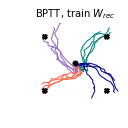

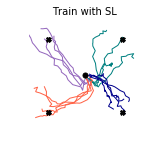

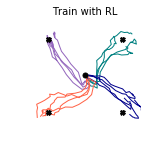

In [58]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='BPTT, train '+r'$W_{rec}$')
fig1 = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='Train with SL')
fig2 = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4],title='Train with RL')


save = True
paper = True

if paper:
    fig0,_ = paper_format(fig=fig0,ax=fig0.gca(),xlabels=None,ylabels=None,xlim=[-1.5,1.5],ylim=[-1.5,1.5],figsize=(2,2),labelsize=10)
    fig1,_ = paper_format(fig=fig1,ax=fig1.gca(),xlabels=None,ylabels=None,xlim=[-1.5,1.5],ylim=[-1.5,1.5],figsize=(2,2),labelsize=10,tight_layout=True)
    fig2,_ = paper_format(fig=fig2,ax=fig2.gca(),xlabels=None,ylabels=None,xlim=[-1.5,1.5],ylim=[-1.5,1.5],figsize=(2,2),labelsize=10,tight_layout=True)

        
if save:
    
    

    fig0.savefig(folder+'fig2a-BPTT.pdf')
    fig1.savefig(folder+'fig2a-RFLO.pdf')
    fig2.savefig(folder+'fig2a-REINFORCE.pdf')

In [34]:
plot_trained_trajectories??

Signature:
plot_trained_trajectories(
    ['sim', 'tasks: List[task.Task]', 'colors=<itertools.cycle object at 0x7fd6d85e5e58>', 'num_examples: int = 4', '**kwargs'],
)
Source:   
def plot_trained_trajectories(sim, tasks: List[Task],colors=cycle(['teal','C4','darkblue','tomato']),num_examples:int = 4, **kwargs):
    
    """ Plot trajectories after training """
    
    if 'fig' in kwargs.keys():
        fig = kwargs['fig']
        ax = fig.gca()
    else:
        fig,ax = plt.subplots(1,1,figsize=(5,5),squeeze=True) 
        
    if 'title' in kwargs.keys():
        title = kwargs['title']
    else:
        title = 'Trajectories after Training'
    
    for task in tasks:
        c = next(colors)
        for count in range(num_examples):

            sim.run_trial(task,probe_types=['h','pos'],train=False)
            ax.plot(sim.probes['pos'].squeeze()[:,0],sim.probes['pos'].squeeze()[:,1],'-',color=c)

    ax.set_xticks([-1,1])
    ax.set_yticks([-1,1])
    for task in tasks:
       

In [42]:
paper_format??

Signature:
paper_format(
    ['fig', 'ax', 'xlabels=None', 'ylabels=None', 'labelsize=10', 'ticksize=10', 'linewidth=2', 'ylim=[0, 1]', 'figsize=(2.5, 2.5)'],
)
Source:   
def paper_format(fig,ax,xlabels=None,ylabels=None,labelsize=10,ticksize=10,linewidth=2,ylim=[0,1],figsize=(2.5,2.5)):
    
    """ Format Figure for Paper 8.5 x 11 
    
    This allows for quick reformatting of figures
    
    Args
    ----
    labelsize
    ticksize
    linewidth
    ylim
    figsize
    
    Returns
    -------
    fig
    ax
    
    TO DO: Need to be able to set linewidth
    """
    
    ax.set_ylim(ylim)
    
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])
    
    ax.xaxis.label.set_size(labelsize)
    ax.yaxis.label.set_size(labelsize)
    
    ax.tick_params(axis='x', labelsize=ticksize)
    ax.tick_params(axis='y', labelsize=ticksize)
    
    ax.set_title(ax.get_title(),fontsize=labelsize)
    
    """ for small figures """
    if xlabels:
        ax.xaxis.set_major_lo

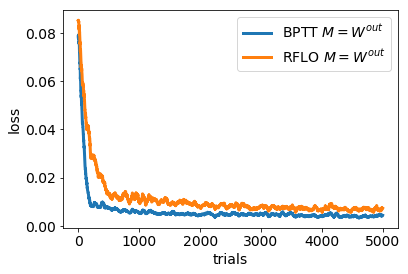

In [88]:
lw=3

fig,ax = plt.subplots(1,1)
av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),50)
ax.plot(av0,linewidth=lw,label='BPTT '+'$M=W^{out}$')

av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),50)
ax.plot(av1,linewidth=lw,label='RFLO '+r'$M = W^{out}$')
ax.legend()
ax.set_xlabel('trials')
ax.set_ylabel('loss')
plt.show()

#ax.fill_between(np.arange(len(av1)),av1-std1,av1+std1,alpha=0.5)
#std1 = uniform_filter1d(np.std(sim1.session_probes['loss'],axis=1),50)


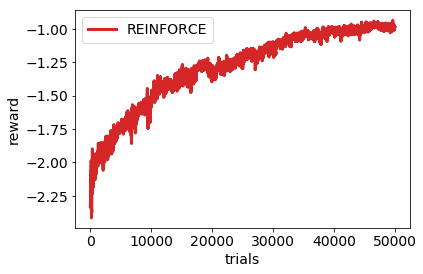

In [90]:
fig,ax = plt.subplots(1,1)
av2 = uniform_filter1d(np.mean(sim2.session_probes['reward'],axis=1),50)
ax.plot(av2,linewidth=lw,label='REINFORCE',color='C3')
ax.legend()
ax.set_xlabel('trials')
ax.set_ylabel('reward')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=None,linewidth=2,ylim=[-0.05,0.6],figsize=(2.25,3),labelsize=10)

plt.show()

if save:
    fig.savefig(folder+'reinforce-example-reward.pdf')


# Compare alignment of M for RFLO

14it [00:00, 136.63it/s]

M norm: 1.04	 M angle: 0.80, 4 iterations

1500it [00:05, 297.81it/s]
31it [00:00, 301.50it/s]

M norm: 1.38	 M angle: 0.60, 7 iterations

1500it [00:03, 376.21it/s]
27it [00:00, 266.50it/s]

M norm: 1.61	 M angle: 0.39, 40 iterations

1500it [00:03, 376.85it/s]
32it [00:00, 319.94it/s]

M norm: 1.82	 M angle: 0.00, 7 iterations

1500it [00:03, 418.47it/s]


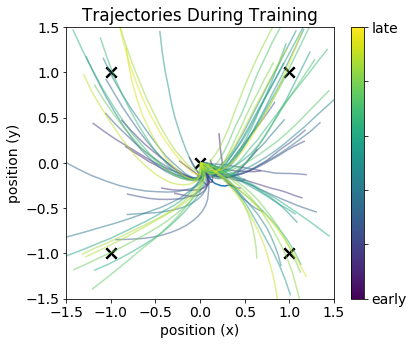

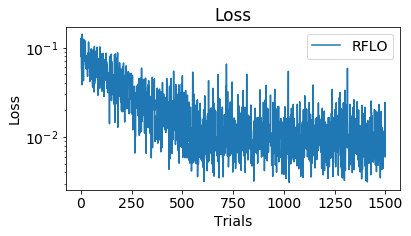

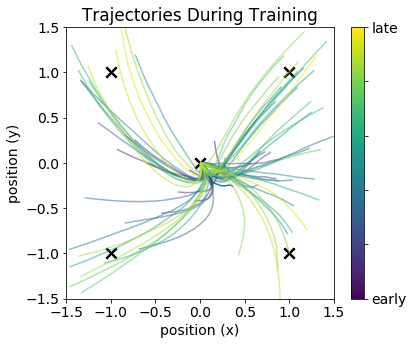

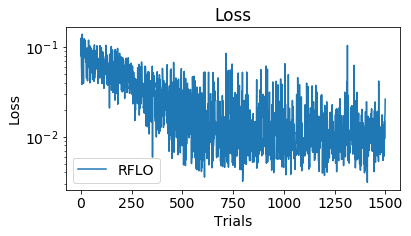

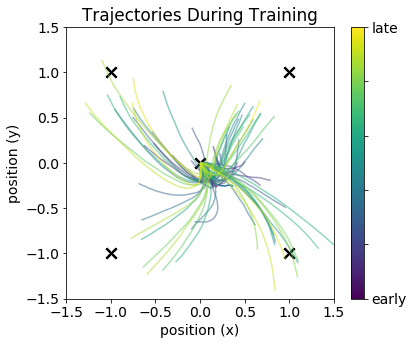

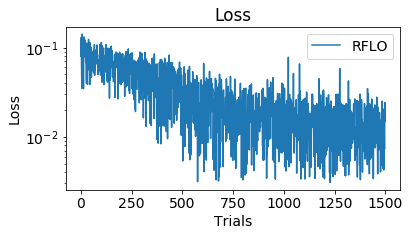

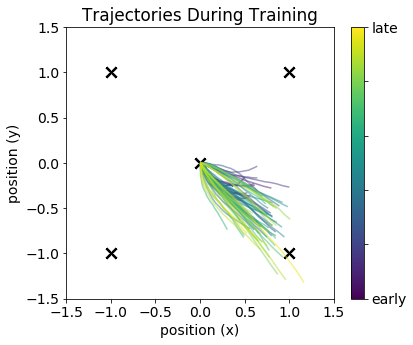

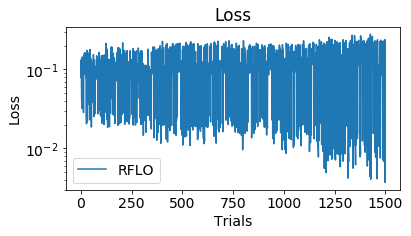

In [38]:

loss_dict = {}

overlaps = [0.8,0.6,0.4,0]
n_changes = [30,50,75,100]
for overlap, n_change in zip(overlaps,n_changes):
    
    net1a = RNN(params)
    
    M = choose_aligned_matrix(net1a.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000,rng=np.random.RandomState(1977))
    net1a.set_weights(w_m = M.T)
    
    sim1a = Simulation(net1a)
    rfloa = RFLO(net1a,apply_to=['w_rec'],online=False)
    sim1a.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[rfloa], probe_types=['loss'], plot=True, plot_freq=20)

    av1a = uniform_filter1d(np.mean(sim1a.session_probes['loss'],axis=1),25)
    
    loss_dict[str(overlap)] = av1a


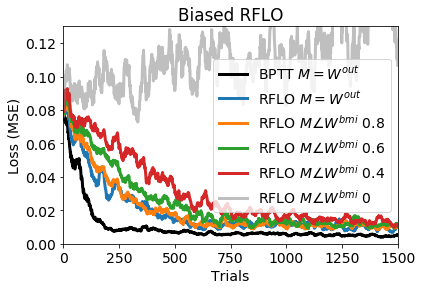

In [39]:
lw=3

fig,ax = plt.subplots(1,1)
av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),25)
ax.plot(av0,linewidth=lw,label='BPTT '+'$M=W^{out}$',color='k')

av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),25)
ax.plot(av1,linewidth=lw,label='RFLO '+r'$M = W^{out}$')



for overlap,loss in loss_dict.items():
    
    if overlap != '0' and overlap != '1':
        ax.plot(loss,linewidth=lw,label='RFLO '+r'$M \angle W^{bmi}$ '+overlap)
        
    if overlap == '0':
        ax.plot(loss,linewidth=lw,label='RFLO '+r'$M \angle W^{bmi}$ '+overlap,alpha=0.5,color='grey')

#ax.legend(bbox_to_anchor=(0.7,1))
ax.legend()
ax.set_xlabel('Trials')
ax.set_ylabel('Loss (MSE)')
ax.set_ylim([0,0.13])
ax.set_xlim([0,1500])
plt.title('Biased RFLO')
plt.show()

save = True
if save:
    fig.savefig(folder+'example-RFLO-changeM.pdf')